In [1]:
"""simulation for the Hyperdrive market"""
from __future__ import annotations
import json
import pandas as pd
import os
import numpy as np
import elfpy
from elfpy.wallet.wallet import Wallet
import mplfinance as mpf

In [2]:
# Hard coding location for now
trans_data = "../artifacts/hyperTransRecs_updated.json"

with open(trans_data, 'r', encoding='utf8') as f:
    json_data = json.load(f)

data = pd.DataFrame(json_data)

In [3]:
data.columns

Index(['blockHash', 'blockNumber', 'from', 'gas', 'gasPrice',
       'maxPriorityFeePerGas', 'maxFeePerGas', 'hash', 'input', 'nonce', 'to',
       'transactionIndex', 'value', 'type', 'accessList', 'chainId', 'v', 'r',
       's', 'timestamp', 'txreceipt_status', 'isError', 'contractAddress',
       'decoded_logs', 'decoded_input'],
      dtype='object')

In [4]:
def get_decoded_logs(data):
    timestamps = data['timestamp']
    decoded_logs = data['decoded_logs'].reset_index().explode('decoded_logs')
    index = decoded_logs['index']
    decoded_logs = pd.json_normalize(decoded_logs['decoded_logs'])
    decoded_logs['timestamp'] = pd.to_datetime(timestamps.loc[index].values, unit='s')
    # Filter for only transfers
    decoded_logs['data_index'] = index.values
    decoded_logs = decoded_logs[decoded_logs['event'] == "TransferSingle"]
    return decoded_logs
    

In [5]:
def get_decoded_input(data):
    timestamps = data['timestamp']
    decoded_input = pd.json_normalize(data['decoded_input'])
    decoded_input['timestamp'] = pd.to_datetime(timestamps, unit='s')
    return decoded_input
    

In [6]:
def calculate_spot_price(decoded_logs):
    # Hard coding variables to calculate spot price
    initial_share_price = 1
    time_remaining_stretched = 0.045071688063194093
    spot_price = ((initial_share_price * (decoded_logs['block_info.shareReserves_']/1e18)) /
        ((decoded_logs['block_info.bondReserves_']/1e18) + (decoded_logs['block_info.lpTotalSupply']/1e18))
                 ) ** time_remaining_stretched
    return spot_price

In [11]:
def calc_ohlcv(data, freq='D'):
    decoded_logs = get_decoded_logs(data)
    decoded_logs['spot_price'] = calculate_spot_price(decoded_logs)
    decoded_logs['value'] = decoded_logs['args.value']/1e18
    decoded_logs = decoded_logs.set_index('timestamp')
    
    ohlcv = decoded_logs.groupby([
        pd.Grouper(freq=freq)
    ]).agg({'spot_price':['first', 'last', 'max', 'min'], 'value':'sum'})
    
    ohlcv.columns = ['Open', 'Close', 'High', 'Low', 'Volume']
    ohlcv.index.name = 'Date'
    
    return ohlcv.astype(float)
    

In [12]:
ohlcv = calc_ohlcv(data)

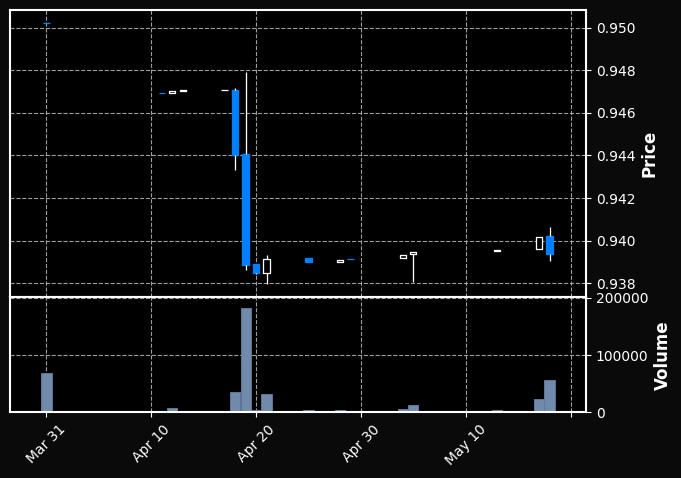

In [13]:
mpf.plot(ohlcv, style='mike', type='candle', volume=True)